# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

# Variable definition:

tweet_id: Unique identifier of the tweet
safe_tweet: Text contained in the tweet. Some sensitive information has been removed like usernames and urls
label: Sentiment of the tweet (-1 for negative, 0 for neutral, 1 for positive)
agreement: The tweets were labeled by three people. Agreement indicates the percentage of the three reviewers that agreed on the given label. You may use this column in your training, but agreement data will not be shared for the test set.

In [1]:
pip install nfx


In [2]:
#Hugging face hub
!pip install huggingface_hub


In [3]:
pip install neattext


In [4]:
pip install datasets


In [5]:
!pip install transformers


In [6]:
from transformers import TrainingArguments
!pip install transformers[torch]
!pip install accelerate -U
!pip install -qU transformers datasets accelerate

In [7]:
import os
import pandas as pd
#Import hugging face logging in
from huggingface_hub import notebook_login
#Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split
#Visualization Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
# To extract hashtags
import neattext.functions as nfx
import re
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')
# Download stopwords - Stopwords are commonly used words "a", "the" , "an", "is", "are".
# Are removed since they dont carry significant meaning to the words

# import specific functions and classes from NLTK (Natural Language Toolkit library)

from nltk.tokenize import word_tokenize  # used for tokenizing text into individual words
from nltk.corpus import stopwords # provides a list of common words that are often removed from text
from nltk.stem import PorterStemmer # is a stemming algorithm that reduces words to their base or root form

# Initializes stop variable, assigns it the list of English stopwords from the NLTK corpus.

import nltk
nltk.download("stopwords")
# creates an instance of the PorterStemmer class, assigns it to the variable stemmer.
# The stemmer will be used later to perform word stemming, which reduces words to their base or root
stemmer = PorterStemmer()

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [77]:
notebook_login()



In [9]:
!pip install download

In [10]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [11]:
# Load the dataset and display some values
Link = 'https://raw.githubusercontent.com/Newton23-nk/Covid_Vaccine_Sentiment_Analysis/main/Datasets/Train.csv'
df = pd.read_csv(Link)

# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]


# Exploratory Data Analysis

In [12]:
df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [13]:
# We look at the number of positive, negative and neutral reviews
df.label.value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

In [14]:
# The count of the agrremtns
df.agreement.value_counts()

1.000000    5866
0.666667    3894
0.333333     239
Name: agreement, dtype: int64

In [15]:
# Legnth of the reviews
review_legnth = df.safe_text.str.len()


In [16]:
# Legnth of the longest review
max(review_legnth)

153

In [17]:
#Legnth of the shortest review
min(review_legnth)

3

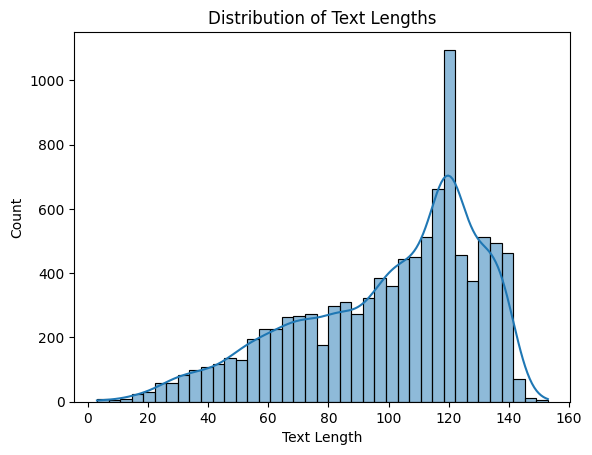

In [18]:
# Length of Tweets
text_length = df['safe_text'].apply(len)
sns.histplot(text_length, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

The highest text length observed is 153 characters, while the minimum text length is 3 characters.

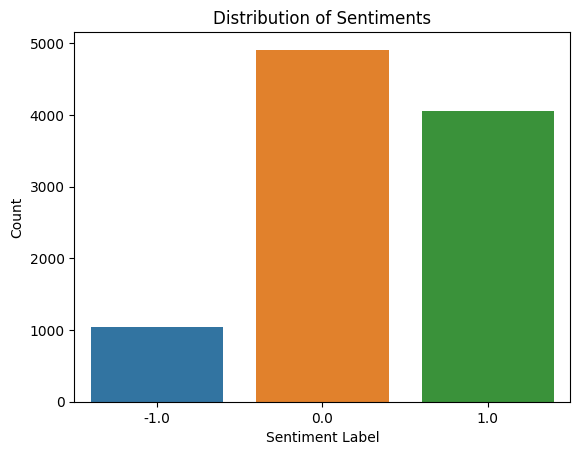

In [19]:
# Distribution of Sentiments
sns.countplot(x='label', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

The distribution of sentiments in the dataset, as depicted by the count plot, shows the prevalence of different sentiment labels within the Twitter posts related to COVID-19 vaccinations.
* Sentiment Label 0 (Neutral):
The sentiment label "0" (neutral) has the highest count, with approximately 5000 instances. This suggests that a significant portion of the collected tweets exhibit a neutral sentiment when it comes to discussing COVID-19 vaccinations. Neutral sentiments often indicate that the tweets may not strongly express positive or negative opinions but rather present factual information or observations.

* Sentiment Label 1 (Positive):
The sentiment label "1" (positive) follows with around 4000 instances. This indicates that a substantial number of tweets show a positive sentiment towards COVID-19 vaccinations. These tweets might express support for vaccinations, share positive experiences, or provide information about vaccination availability and benefits.

* Sentiment Label -1 (Negative):
The sentiment label "-1" (negative) has the lowest count, with approximately 1000 instances. This suggests that a relatively smaller portion of the collected tweets exhibit a negative sentiment towards COVID-19 vaccinations. Negative sentiments can encompass concerns, skepticism, or criticism about the vaccines, their safety, or potential side effects.

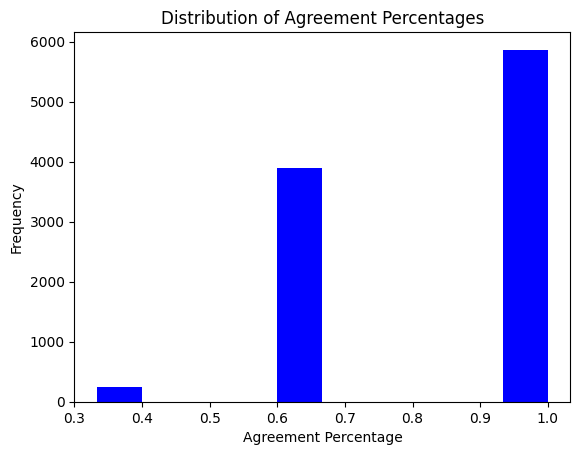

In [20]:
# Distribution of Agreement Percentages
plt.hist(df['agreement'], color='blue')
plt.title('Distribution of Agreement Percentages')
plt.xlabel('Agreement Percentage')
plt.ylabel('Frequency')
plt.show()

* From the distribution plot, it is clear that the majority of tweets have an agreement percentage of 1.000000 (100% agreement among reviewers).
This means that for a significant portion of tweets, all three reviewers assigned the same sentiment label without disagreement.
* For a substantial number of tweets, two out of three reviewers agreed on the assigned sentiment label with a count of 3894.
* Finally, a smaller number of tweets have an agreement percentage of 0.333333, indicating that only one out of three reviewers agreed on the label.

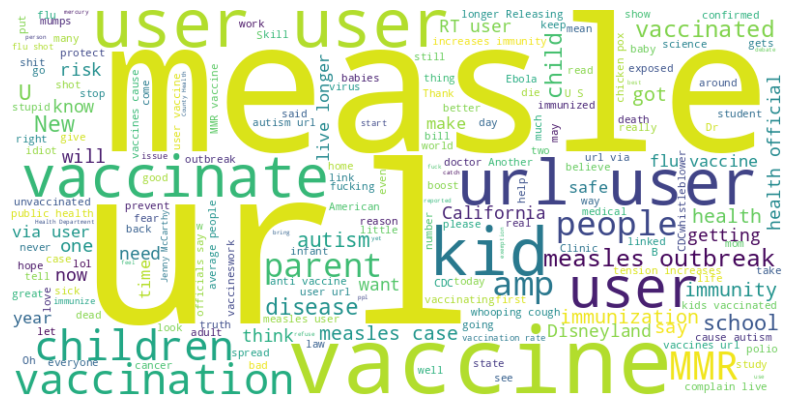

In [21]:
# Concatenate all text from the 'safe_text' column into a single string
text = ' '.join(df['safe_text'])

# Generate the word cloud with a white background
cloud_two_cities = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(cloud_two_cities, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=1)
plt.show()


* The high frequency of "vaccine" and "vaccinate" aligns with the overarching theme of COVID-19 vaccinations. Neutral sentiment tweets may contain factual information, discussions, or updates related to the vaccines, contributing to a neutral tone.
* The term "measles" appearing prominently suggests that discussions within the neutral sentiment category often include references to the measles virus. It's possible that some tweets are drawing comparisons or discussing related topics in the context of COVID-19 vaccinations.
* The appearance of "kid" and "children" indicates that discussions involving younger individuals, possibly in the context of vaccination decisions for children, are present within the neutral sentiment tweets.

# Data Cleaning

In [22]:
# Checking for missing values
df.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [23]:
df.duplicated().sum()

0

We will extract hashtags and which can also used for analysis like which was the common aside from #Covid #Vaccine

In [24]:
# get hashtags
df['extract_hashtags'] = df['safe_text'].apply(nfx.extract_hashtags)
df[['extract_hashtags','safe_text']]

,extract_hashtags,safe_text
0,"[#MEANBOY, #MB, #MBS, #MMR, #STEGMANLIFE]",Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1,[],I'm 100% thinking of devoting my career to pro...
2,[#whatcausesautism],"#whatcausesautism VACCINES, DO NOT VACCINATE Y..."
3,[],I mean if they immunize my kid with something ...
4,"[#jennifair, #mmr…]",Thanks to <user> Catch me performing at La Nui...
...,...,...
9996,[#vaccineswork],Living in a time where the sperm I used to was...
9997,[],<user> <user> In spite of all measles outbrea...
9998,[],Interesting trends in child immunization in Ok...
9999,[],CDC Says Measles Are At Highest Levels In Deca...


In [25]:
# remove hashtags from the column and save the cleaned text to clean text column
df['clean_text'] = df['safe_text'].apply(nfx.remove_hashtags)

# preview
df[['safe_text','clean_text']].head(10)

,safe_text,clean_text
0,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,Me &amp; The Big Homie meanboy3000 @...
1,I'm 100% thinking of devoting my career to pro...,I'm 100% thinking of devoting my career to pro...
2,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...","VACCINES, DO NOT VACCINATE YOUR CHILD"
3,I mean if they immunize my kid with something ...,I mean if they immunize my kid with something ...
4,Thanks to <user> Catch me performing at La Nui...,Thanks to <user> Catch me performing at La Nui...
5,<user> a nearly 67 year old study when mental ...,<user> a nearly 67 year old study when mental ...
6,"Study of more than 95,000 kids finds no link b...","Study of more than 95,000 kids finds no link b..."
7,psa: VACCINATE YOUR FUCKING KIDS,psa: VACCINATE YOUR FUCKING KIDS
8,Coughing extra on the shuttle and everyone thi...,Coughing extra on the shuttle and everyone thi...
9,AIDS vaccine created at Oregon Health &amp; Sc...,AIDS vaccine created at Oregon Health &amp; Sc...


We will remove the user handles and the "RT" retweet indicator using the nfx.remove_userhandles in the nfx library.

In [26]:
# remove RT and user handles
def removeRT(text):
    return text.replace("RT" , "")
df['clean_text'] = df['clean_text'].apply(lambda x: nfx.remove_userhandles(x))
df['clean_text'] = df['clean_text'].apply(removeRT)
#Preview of the safe text and clean text
df[['safe_text','clean_text']].head(10)


,safe_text,clean_text
0,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,Me &amp; The Big Homie meanboy3000 @...
1,I'm 100% thinking of devoting my career to pro...,I'm 100% thinking of devoting my career to pro...
2,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...","VACCINES, DO NOT VACCINATE YOUR CHILD"
3,I mean if they immunize my kid with something ...,I mean if they immunize my kid with something ...
4,Thanks to <user> Catch me performing at La Nui...,Thanks to <user> Catch me performing at La Nui...
5,<user> a nearly 67 year old study when mental ...,<user> a nearly 67 year old study when mental ...
6,"Study of more than 95,000 kids finds no link b...","Study of more than 95,000 kids finds no link b..."
7,psa: VACCINATE YOUR FUCKING KIDS,psa: VACCINATE YOUR FUCKING KIDS
8,Coughing extra on the shuttle and everyone thi...,Coughing extra on the shuttle and everyone thi...
9,AIDS vaccine created at Oregon Health &amp; Sc...,AIDS vaccine created at Oregon Health &amp; Sc...


We then remove multiple spaces and strip any leading or trailing spaces using the nfx.remove_multiple_spaces function and a custom function stripSpace.

In [27]:
# remove multiple white spaces
def stripSpace(text):
    return text.strip()
df['clean_text'] = df['clean_text'].apply(nfx.remove_multiple_spaces)
df['clean_text'] = df['clean_text'].apply(stripSpace)

To further reduce noise in the data and to remove irrelevant content, we will remove URLs from the data

In [28]:
# remove all urls
df['clean_text'] = df['clean_text'].apply(nfx.remove_urls)

df[['safe_text','clean_text']].head(10)

,safe_text,clean_text
0,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,Me &amp; The Big Homie meanboy3000 @ Stegman S...
1,I'm 100% thinking of devoting my career to pro...,I'm 100% thinking of devoting my career to pro...
2,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...","VACCINES, DO NOT VACCINATE YOUR CHILD"
3,I mean if they immunize my kid with something ...,I mean if they immunize my kid with something ...
4,Thanks to <user> Catch me performing at La Nui...,Thanks to <user> Catch me performing at La Nui...
5,<user> a nearly 67 year old study when mental ...,<user> a nearly 67 year old study when mental ...
6,"Study of more than 95,000 kids finds no link b...","Study of more than 95,000 kids finds no link b..."
7,psa: VACCINATE YOUR FUCKING KIDS,psa: VACCINATE YOUR FUCKING KIDS
8,Coughing extra on the shuttle and everyone thi...,Coughing extra on the shuttle and everyone thi...
9,AIDS vaccine created at Oregon Health &amp; Sc...,AIDS vaccine created at Oregon Health &amp; Sc...


We will remove punctuation to standardize the data and to ensure consistency in the data

In [29]:
# remove pucntuations
df['clean_text'] = df['clean_text'].apply(nfx.remove_puncts)

df[['safe_text','clean_text']].head(10)

,safe_text,clean_text
0,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,Me amp The Big Homie meanboy3000 @ Stegman St ...
1,I'm 100% thinking of devoting my career to pro...,Im 100% thinking of devoting my career to prov...
2,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",VACCINES DO NOT VACCINATE YOUR CHILD
3,I mean if they immunize my kid with something ...,I mean if they immunize my kid with something ...
4,Thanks to <user> Catch me performing at La Nui...,Thanks to <user> Catch me performing at La Nui...
5,<user> a nearly 67 year old study when mental ...,<user> a nearly 67 year old study when mental ...
6,"Study of more than 95,000 kids finds no link b...",Study of more than 95000 kids finds no link be...
7,psa: VACCINATE YOUR FUCKING KIDS,psa: VACCINATE YOUR FUCKING KIDS
8,Coughing extra on the shuttle and everyone thi...,Coughing extra on the shuttle and everyone thi...
9,AIDS vaccine created at Oregon Health &amp; Sc...,AIDS vaccine created at Oregon Health amp Scie...


In [30]:
# lets check on null text, some might be cleaned everything
df.isna().sum()

tweet_id            0
safe_text           0
label               0
agreement           0
extract_hashtags    0
clean_text          0
dtype: int64

We then remove punctuation from each hashtag and also remove the '#' symbol. This is to standardize hashtag representations.

In [31]:
# lets get hashtags into a good string and remove the hashes beside the tag
def clean_hash_tag(text):
    return " ".join([nfx.remove_puncts(x).replace("#", "") for x in text])

df['extract_hashtags'] = df['extract_hashtags'].apply(clean_hash_tag)

## Dealing with Emojis

In [32]:
# dealing with emojis
df['clean_text'].apply(nfx.extract_emojis)

0        []
1        []
2        []
3        []
4        []
         ..
9996     []
9997     []
9998     []
9999     []
10000    []
Name: clean_text, Length: 9999, dtype: object

In [33]:
# removing the emojis
df['clean_text'] = df['clean_text'].apply(nfx.remove_emojis)

In [34]:
# Replace '<user>' with an empty string in the 'clean_text' column
df['clean_text'] = df['clean_text'].str.replace('<user>', '')
df['clean_text'] = df['clean_text'].str.replace('@', '')
df['clean_text'] = df['clean_text'].str.replace('<url>', '')
df['clean_text'] = df['clean_text'].str.replace('measles', 'Measles')
df['clean_text'] = df['clean_text'].str.replace('“', '')


* * Remove ['vaccine', 'vaccines', 'vaccinate', 'vaccinated', 'vaccinations', 'vaccination'] to ['vaccine'] **

In [35]:
#We define the words to replace
words_to_replace = ['vaccine', 'vaccines', 'vaccinate', 'vaccinated', 'vaccinations', 'vaccination']

# Pattern to match any of the words in the list, using a regular expression
pattern = r'\b(?:{})\b'.format('|'.join(words_to_replace))

# Function to replace the words with 'vaccine'
def replace_with_vaccine(text):
    return text.str.replace(pattern, 'vaccine', case=False)

# Apply the function to the 'safe_text' column
df['clean_text'] = replace_with_vaccine(df['clean_text'])

**4.8 Replace ['kids', 'child', 'children'] to ['child']**

In [36]:
words_to_replace_2 = ['kids', 'child', 'children']

# Pattern to match any of the words in the list, using a regular expression
pattern_2  = r'\b(?:{})\b'.format('|'.join(words_to_replace_2 ))

# Function to replace the words with 'vaccine'
def replace_with_child (text):
    return text.str.replace(pattern_2 , 'child', case=False)

# Apply the function to the 'safe_text' column
df['clean_text'] = replace_with_child(df['clean_text'])

In [37]:
!pip install nltk
import nltk

In [38]:
words_ = nltk.FreqDist(df['clean_text'].str.split().sum())
words = words_.most_common(30)

words

[('vaccine', 4902),
 ('to', 3435),
 ('the', 3413),
 ('Measles', 3022),
 ('child', 2487),
 ('of', 2212),
 ('a', 2142),
 ('in', 1926),
 ('and', 1837),
 ('I', 1635),
 ('is', 1501),
 ('for', 1489),
 ('you', 1019),
 ('your', 950),
 ('are', 925),
 ('that', 908),
 ('have', 902),
 ('not', 820),
 ('on', 788),
 ('their', 728),
 ('get', 678),
 ('be', 669),
 ('at', 668),
 ('my', 667),
 ('with', 665),
 ('The', 634),
 ('from', 627),
 ('this', 612),
 ('who', 609),
 ('it', 607)]

## Removing Stop words

In [39]:
",".join(stopwords.words('english'))

"i,me,my,myself,we,our,ours,ourselves,you,you're,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his,himself,she,she's,her,hers,herself,it,it's,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,that'll,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,s,t,can,will,just,don,don't,should,should've,now,d,ll,m,o,re,ve,y,ain,aren,aren't,couldn,couldn't,didn,didn't,doesn,doesn't,hadn,hadn't,hasn,hasn't,haven,haven't,isn,isn't,ma,mightn,mightn't,mustn,mustn't,needn,needn't,shan,shan't,shouldn,shouldn't,wasn,wasn't,weren,weren't,won,won't,wouldn,wouldn't"

In [40]:
stop_words = set(stopwords.words('english'))

In [41]:
# Convert safe_text column to lower so as to apply stop words

df['clean_text'] = df['clean_text'].str.lower()

In [42]:
# remove stop words
def remove_stop (x):
  return ",".join([word for word in str(x).split() if word not in stop_words])


df['clean_text'] = df['clean_text'].apply(lambda x : remove_stop(x) )

In [43]:
# To remove punctuations
df['clean_text'] = df['safe_text'].str.replace(r"[&;. ,#@\"!']", " ", regex=True)


## Use Stemmetizaton

In [44]:
ps = PorterStemmer()

In [45]:
final = []
for word in df['clean_text']:
   final.append(ps.stem(word))
   final.append(" ")

In [46]:
df.head()

,tweet_id,safe_text,label,agreement,extract_hashtags,clean_text
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0,MEANBOY MB MBS MMR STEGMANLIFE,Me amp The Big Homie meanboy3000 MEANBOY M...
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0,,I m 100% thinking of devoting my career to pro...
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0,whatcausesautism,whatcausesautism VACCINES DO NOT VACCINATE Y...
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,,I mean if they immunize my kid with something ...
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0,jennifair mmr…,Thanks to <user> Catch me performing at La Nui...


In [47]:
# We Replace ['-', '"', 'u'] with [ ]
words_to_replace_3 = ['-', '"', 'u' ]

# Pattern to match any of the words in the list, using a regular expression
pattern_3  = r'\b(?:{})\b'.format('|'.join(words_to_replace_3 ))

# Function to replace the words with 'vaccine'
def replace_with_vaccine_3 (text):
    return text.str.replace(pattern_3 , '', case=False)

# Apply the function to the 'safe_text' column
df['clean_text'] = replace_with_vaccine_3(df['clean_text'])

In [48]:
df = df[['tweet_id','clean_text','label','agreement']]

In [49]:
df.head()

,tweet_id,clean_text,label,agreement
0,CL1KWCMY,Me amp The Big Homie meanboy3000 MEANBOY M...,0.0,1.0
1,E3303EME,I m 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,whatcausesautism VACCINES DO NOT VACCINATE Y...,-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweet_id    9999 non-null   object 
 1   clean_text  9999 non-null   object 
 2   label       9999 non-null   float64
 3   agreement   9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


## Data Splitting

We will split the training set to have a training subset ( a dataset the model will learn on), and an evaluation subset ( a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one ).

There are multiple ways to do split the dataset.You will see two commented line showing you another one.

In [51]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [52]:
train.head()

,tweet_id,clean_text,label,agreement
9305,YMRMEDME,Mickey s Measles has gone international <url>,0.0,1.000000
3907,5GV8NEZS,S1256 [NEW] Extends exemption from charitable ...,0.0,1.000000
795,EI10PS46,<user> your ignorance on vaccines isn t just ...,1.0,0.666667
5793,OM26E6DG,Pakistan partly suspends polio vaccination pro...,0.0,1.000000
3431,NBBY86FX,In other news I ve gone up like 1000 mmr,0.0,1.000000


In [53]:
eval.head()

,tweet_id,clean_text,label,agreement
6571,R7JPIFN7,Children s Museum of Houston to Offer Free Vac...,1.0,1.000000
1754,2DD250VN,<user> no I was properly immunized prior to t...,1.0,1.000000
3325,ESEVBTFN,<user> thx for posting vaccinations are impera...,1.0,1.000000
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1.0,0.666667
4175,IIN5D33V,Meeting tonight 8:30pm in room 322 of the stu...,1.0,1.000000


In [54]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 4), eval is (2000, 4)


We will create a directory and save the 'train_subset.csv' and 'eval_subset.csv' files within that directory.

In [55]:
# To create a director to hold the datasets
if not os.path.exists('LP5 Dataset'):
  os.makedirs('LP5 Dataset')

In [56]:
# To check if the directory has been created
if os.path.exists('LP5 Dataset'):
  print('The dataset directory exists')
else:
  print("The dataset directory does not exist")

The dataset directory exists


In [57]:
# Save splitted subsets in the dataset folder we created
train.to_csv("./LP5 Dataset/train_subset.csv", index=False)
eval.to_csv("./LP5 Dataset/eval_subset.csv", index=False)

In [58]:
dataset = load_dataset('csv',
                        data_files={'train': './LP5 Dataset/train_subset.csv',
                        'eval': './LP5 Dataset/eval_subset.csv'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [59]:
#To check if the dataset has been loaded properly
dataset

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'clean_text', 'label', 'agreement'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['tweet_id', 'clean_text', 'label', 'agreement'],
        num_rows: 2000
    })
})

# BERT-BASED  MODEL
BERT (Bidirectional Encoder Representations from Transformers) is a popular pre-trained model architecture for natural language understanding and processing. The "base" version of BERT, often referred to as "BERT base," represents a standard configuration of the BERT model. The "cased" variant of BERT retains the original casing of words in the pre-trained embeddings, which means it differentiates between uppercase and lowercase characters.

Here's what "BERT base cased" typically refers to:

1. **Base Model**: The "base" version of BERT usually refers to a model with a certain number of layers, hidden units, and attention heads. The specific architecture can vary, but it's a medium-sized version of BERT that balances computational cost and performance. For instance, it might have 12 layers, 768 hidden units, and 12 attention heads.

2. **Cased**: The "cased" variant of BERT retains the case information of words. This means that it treats "Word" and "word" as distinct tokens, capturing the difference in case. This can be important for tasks where the case of words carries semantic meaning.

BERT base cased is trained on a large corpus of text and can be fine-tuned for various natural language processing tasks, such as text classification, named entity recognition, question-answering, and more. Researchers and practitioners often use BERT base cased as a starting point for their NLP tasks because it provides strong out-of-the-box performance.

You can access pre-trained BERT base cased models and their corresponding tokenizers from the Hugging Face Transformers library, which is a popular library for working with pre-trained models in NLP. These models are available in various languages and can be loaded and fine-tuned for specific NLP tasks.

If you have more specific questions about using BERT base cased for a particular task or need code examples, feel free to ask!



## Preprocessing
Tokenization is the process of splitting raw text into smaller units called tokens. Tokens are typically words or subwords. Tokenization is a fundamental step in NLP because it breaks down text data into manageable units that can be processed by NLP models. In this case we are using a pretrained tokenizer from Hugging Face's Transformers library.

We will import the AutoTokenizer class from the Hugging Face Transformers library and then create an instance of the AutoTokenizer class and initializes it with a pre-trained BERT tokenizer.

In [86]:
# Import Autokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')


We define a function tokenize_function takes an input argument, which is expected to be a dictionary. This dictionary should contain a key 'text' that corresponds to the text data you want to tokenize. The function, then calls the tokenizer object that was initialized earlier. It tokenizes the text data provided.

Padding is the process of adding special tokens (often <PAD>) to the sequences to make them uniform in length. Setting padding='max_length' in the tokenizer ensures that all tokenized sequences have the same maximum length.


The padding argument specifies that the tokenized sequences should be padded to the maximum sequence length in the batch. Padding ensures that all sequences have the same length.


In [87]:
#A function to tockenize the data
def tokenize_function(df):
    return tokenizer(df['clean_text'], padding='max_length')


We apply the tokenize_data function to the dataset using the map function, in a
batched manner. This will tokenize each text field and padding the sequences to the maximum length in the batch.

The argument 'batched=True' allows to efficiently tokenize and pad multiple examples in a batch. Batch processing is essential for speeding up NLP tasks, as it allows the processing of multiple examples in parallel, which is especially beneficial when working with large datasets.

In [88]:
# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

We define a function that will transform the sentiments labels from -1, 0, and 1 and converts them into a numerical format such that -1 becomes 0, 0 becomes 1, and 1 becomes 3.

In [89]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

In [90]:
# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'agreement','clean_text']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [91]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [92]:
# SPecifying the training arguments
from transformers import TrainingArguments

# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
training_args = TrainingArguments("Covid_Vaccine_Sentiment_Analysis_Bert_based_Model",
                                  num_train_epochs=10,
                                  load_best_model_at_end=True,
                                  push_to_hub=True,
                                  evaluation_strategy="steps",
                                  save_strategy="steps")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


The AutoModelForSequenceClassification provides a unified interface for loading various pre-trained models (like BERT, RoBERTa, etc.) and fine-tuning them for sequence classification tasks.WE will load the pre-trained BERT model and configures it for sequence classification with the specified number of labels

In [93]:
# We import the AutomodelForSequenceClassificatio class from the Transformers library
from transformers import AutoModelForSequenceClassification

# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
# We shuffle the dataset to randomnize the data and avoid any bias
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

## other way to split the train set ... in the range you must use:
# # int(num_rows*.8 ) for [0 - 80%] and  int(num_rows*.8 ),num_rows for the 20% ([80 - 100%])
# train_dataset = dataset['train'].shuffle(seed=10).select(range(40000))
# eval_dataset = dataset['train'].shuffle(seed=10).select(range(40000, 41000))

We initialize the Trainer object from the Transformers library. The Trainer class is a high-level API that simplifies the training and evaluation of transformer-based models for various

In [95]:
# WE import the Trainer class from the Transformers library.
from transformers import Trainer

# We initialize the trainer object and specify the arguments
trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset
)

In [96]:
# Launch the learning process: training
trainer.train()

Step,Training Loss,Validation Loss
500,0.746900,0.728293
1000,0.691000,0.645709
1500,0.582800,0.674053
2000,0.572300,0.617940
2500,0.414500,0.840968
3000,0.404400,0.780854
3500,0.259200,1.119162
4000,0.293200,1.270593
4500,0.162000,1.355937
5000,0.184600,1.293014


TrainOutput(global_step=10000, training_loss=0.24322458848953246, metrics={'train_runtime': 8540.4084, 'train_samples_per_second': 9.366, 'train_steps_per_second': 1.171, 'total_flos': 2.104644228406272e+16, 'train_loss': 0.24322458848953246, 'epoch': 10.0})

In [97]:
#To push the trained model into hugging face model hub
trainer.push_to_hub()


'https://huggingface.co/NewtonKimathi/Covid_Vaccine_Sentiment_Analysis_Bert_based_Model/tree/main/'

In [99]:
tokenizer.push_to_hub("NewtonKimathi/Covid_Vaccine_Sentiment_Analysis_Bert_based_Model")

CommitInfo(commit_url='https://huggingface.co/NewtonKimathi/Covid_Vaccine_Sentiment_Analysis_Bert_based_Model/commit/4e7f1e6b1a4f0714c04446d2bc10467724e57711', commit_message='Upload tokenizer', commit_description='', oid='4e7f1e6b1a4f0714c04446d2bc10467724e57711', pr_url=None, pr_revision=None, pr_num=None)

Don't worry the above issue, it is a `KeyboardInterrupt` that means I stopped the training to avoid taking a long time to finish.

In [100]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [101]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [102]:
# Launch the final evaluation
trainer.evaluate()

{'eval_loss': 0.6179400682449341,
 'eval_accuracy': 0.744,
 'eval_runtime': 63.1494,
 'eval_samples_per_second': 31.671,
 'eval_steps_per_second': 3.959}

# Model 2 : Roberta


In [61]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Load pre-trained RoBERTa model and tokenizer
tokenizer_2 = RobertaTokenizer.from_pretrained("roberta-base")
model2 = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
# have the tokenize function with the Tokenizer 2

def tokenize_function_2(df):
    return tokenizer_2(df['clean_text'], padding="max_length")

In [63]:
# using the load_dataset function to load CSV files as datasets
dataset_2 = load_dataset('csv',
                        data_files={'train': './LP5 Dataset/train_subset.csv',
                        'eval': './LP5 Dataset/eval_subset.csv'}, encoding = "ISO-8859-1")

In [64]:
dataset_2

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'clean_text', 'label', 'agreement'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['tweet_id', 'clean_text', 'label', 'agreement'],
        num_rows: 2000
    })
})

In [65]:
# Tokenize the dataset
# Changing the tweets into tokens our model can explot

dataset_2 = dataset_2.map(tokenize_function_2, batched=True)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [66]:
dataset_2

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'clean_text', 'label', 'agreement', 'input_ids', 'attention_mask'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['tweet_id', 'clean_text', 'label', 'agreement', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [67]:
def transform_labels(data):
    label = data['label']  # extracts the value of the 'label' from the data input
    num = 0
    if label == -1:  # 'Negative' sentiment
        num = 0
    elif label == 0:  # 'Neutral' sentiment
        num = 1
    elif label == 1:  # 'Positive' sentiment
        num = 2
    return {"labels": num}

In [68]:
# Assuming you are using the 'transform_labels' function for the mapping
drop = ['tweet_id', 'clean_text', 'label', 'agreement']
dataset_2 = dataset_2.map(transform_labels, remove_columns=drop)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [69]:
dataset_2

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [70]:

# Shuffle the dataset

roberta_train_dataset = dataset_2["train"].shuffle(seed=50)#.take(subset_size)
roberta_eval_dataset = dataset_2["eval"].shuffle(seed=50)

In [71]:
roberta_eval_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 2000
})

In [74]:
# SPecifying the training arguments
from transformers import TrainingArguments

# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
training_args_2 = TrainingArguments("Covid_Vaccine_Sentiment_Analysis_Roberta_Model",
                                  num_train_epochs=5,
                                  load_best_model_at_end=True,
                                  push_to_hub=True,
                                  evaluation_strategy="steps",
                                  save_strategy="steps")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [78]:
# WE import the Trainer class from the Transformers library.
from transformers import Trainer
# Create a trainer

trainer_2 = Trainer(model = model2,args = training_args_2,train_dataset = roberta_train_dataset,
                    eval_dataset = roberta_eval_dataset)

In [79]:
trainer_2.train()

Step,Training Loss,Validation Loss
500,0.793300,0.714130
1000,0.786900,0.762703
1500,0.732500,0.691696
2000,0.729200,0.686629
2500,0.686100,0.717395
3000,0.680000,0.693970
3500,0.622000,0.686874
4000,0.627800,0.700868
4500,0.563100,0.732568
5000,0.558900,0.702088


TrainOutput(global_step=5000, training_loss=0.6779822937011719, metrics={'train_runtime': 4238.9541, 'train_samples_per_second': 9.435, 'train_steps_per_second': 1.18, 'total_flos': 1.052322114203136e+16, 'train_loss': 0.6779822937011719, 'epoch': 5.0})

In [80]:
trainer_2.push_to_hub()

'https://huggingface.co/NewtonKimathi/Covid_Vaccine_Sentiment_Analysis_Roberta_Model/tree/main/'

In [81]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_Metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [83]:
trainer_2 = Trainer(
    model=model2,
    args=training_args_2,
    train_dataset=roberta_train_dataset,
    eval_dataset=roberta_eval_dataset,
    compute_metrics=compute_Metrics,
)

In [84]:
trainer_2.evaluate()

{'eval_loss': 0.6866294145584106,
 'eval_accuracy': 0.7365,
 'eval_runtime': 57.6464,
 'eval_samples_per_second': 34.694,
 'eval_steps_per_second': 4.337}

In [85]:
tokenizer_2.push_to_hub("NewtonKimathi/Covid_Vaccine_Sentiment_Analysis_Roberta_Model")

CommitInfo(commit_url='https://huggingface.co/NewtonKimathi/Covid_Vaccine_Sentiment_Analysis_Roberta_Model/commit/f1e0044365b7ed0a6eae830cf416228679f2e49f', commit_message='Upload tokenizer', commit_description='', oid='f1e0044365b7ed0a6eae830cf416228679f2e49f', pr_url=None, pr_revision=None, pr_num=None)